In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jaxlie import SE3, SO3
import cyipopt
from functools import partial

from sdf_world.sdf_world import *
from sdf_world.robots import *
from sdf_world.util import *

In [2]:
world = SDFWorld()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
panda_model = RobotModel(PANDA_URDF, PANDA_PACKAGE)
panda = Robot(world.vis, "panda", panda_model, alpha=0.5)
panda.reduce_dim([7, 8], [0.04, 0.04])

In [4]:
# ik
robot_dim = 7
horizon = 5
dim = robot_dim * horizon
dt = 0.1

to_mat = lambda x: x.reshape(-1, robot_dim)
to_vec = lambda x: x.flatten()

# def to_qdots_mat(q0, qs):
#     qs = jnp.vstack([q0, to_mat(qs)])
#     return (qs[1:] - qs[:-1]) /dt

In [5]:
# Kinematics
def skew(v):
    v1, v2, v3 = v
    return jnp.array([[0, -v3, v2],
                      [v3, 0., -v1],
                      [-v2, v1, 0.]])

def get_rotvec_angvel_map(v):
    vmag = jnp.linalg.norm(v)
    vskew = skew(v)
    return jnp.eye(3) \
        - 1/2*skew(v) \
        + vskew@vskew * 1/vmag**2 * (1-vmag/2 * jnp.sin(vmag)/(1-jnp.cos(vmag)))

@jax.jit
def get_ee_fk_jac(q):
    # outputs ee_posevec and analytical jacobian
    fks = panda_model.fk_fn(q)
    p_ee = fks[-1][-3:]
    rotvec_ee = SO3(fks[-1][:4]).log()
    E = get_rotvec_angvel_map(rotvec_ee)
    jac = []
    for posevec in fks[1:8]:
        p_frame = posevec[-3:]
        rot_axis = SE3(posevec).as_matrix()[:3, 2]
        lin_vel = jnp.cross(rot_axis, p_ee - p_frame)
        jac.append(jnp.hstack([lin_vel, rot_axis]))
    jac = jnp.array(jac).T
    jac = jac.at[3:, :].set(E @ jac[3:, :])
    return jnp.hstack([p_ee, rotvec_ee]), jac

get_ee_fk = jax.jit(lambda q: get_ee_fk_jac(q)[0])
get_ee_jac = jax.jit(lambda q: get_ee_fk_jac(q)[1])
get_ee_hess = jax.jacrev(get_ee_jac)

In [6]:
frame = Frame(world.vis, "frame")
frame_ee = Frame(world.vis, "frame_ee")
def make_pose():
    return SE3.from_rotation_and_translation(
        SO3(np.random.random(4)).normalize(),
        np.random.uniform([-0.3,-0.5,0.3],[0.6, 0.5, 0.8])
    )

In [15]:
import time
def to_posevec(pose:SE3):
    return jnp.hstack([
        pose.translation(), pose.rotation().log()
    ])

def objective(q, pose_d):
    posevec_d = to_posevec(pose_d)
    error = posevec_d - get_ee_fk(q)
    panda.set_joint_angles(q)
    time.sleep(0.1)
    return 0.5*error@error

def gradient(q, pose_d):
    posevec_d = to_posevec(pose_d)
    ee, jac = get_ee_fk_jac(q)
    error = posevec_d - ee
    # error_mag = jnp.linalg.norm(error)
    # if error_mag > 0.5:
    #     error = error/error_mag * 0.5
    return - jac.T @ error #jac.T

def hessian(q, lagrange, obj_factor, pose_d):
    eps = 1e-6
    posevec_d = to_posevec(pose_d)
    ee, jac = get_ee_fk_jac(q)
    error = posevec_d - ee
    error_mag = jnp.linalg.norm(error)
    print(error_mag)
    if error_mag < 0.5:
        hess = jac.T@jac - (get_ee_hess(q).T @ error)
        # eig_vals, eig_vecs = jnp.linalg.eigh(hess)
        # if eig_vals.min() < eps:
        #     eig_modified = eig_vals.at[eig_vals < eps].set(eps)
        #     hess = eig_vecs @ jnp.diag(eig_modified) @ eig_vecs.T    
        return hess
    else:
        return jnp.eye(7)
    #return jac.T@jac

In [9]:
pose_d = make_pose()
frame.set_pose(pose_d)

In [10]:
q = panda.neutral

In [243]:
# def barrier_fn(x, eps=0.001):
#     def fn_in_transition(x):
#         return (1/6/eps * x**3 + 1/2*x**2 + eps/2*x + eps**2/6)
#     def fn_larger_than_zero(x):
#         return (1/2*x**2 + eps/2*x + eps**2/6)
#     def fn_const_satisfied(x):
#         return 0.
#     x = -x
#     in_transition = (-eps < x) & (x < 0.)
#     larger_than_zero = 0 <= x
#     cond = in_transition + 2*larger_than_zero
#     fns = [fn_const_satisfied, fn_in_transition, fn_larger_than_zero]
#     return jax.lax.switch(cond, fns, x)

# def barrier_fn(x, eps=0.01):
#     def fn_not_active(x):
#         return 0.
#     def fn_in_transition(x):
#         return (1/2/eps)*(x+eps)**2
#     def fn_active(x):
#         return x + 1/2 * eps
#     x = -x
#     is_in_transition = (-eps < x) & (x < 0.)
#     is_active = 0 <= x
#     switch_var = is_active + is_in_transition*2
#     fns = [fn_not_active, fn_active, fn_in_transition]
#     return jax.lax.switch(switch_var, fns, x)

In [11]:
lb = panda.neutral - np.ones(7)*0.6
ub = panda.neutral + np.ones(7)*0.6
ub_viol_err = lambda q: (ub - q) # panda.ub
lb_viol_err = lambda q: (q - lb)
def errors(q):
    posevec_d = to_posevec(pose_d)
    pose_error = posevec_d - get_ee_fk(q)
    return jnp.hstack([pose_error, ub_viol_err(q), lb_viol_err(q)])

def errors_jac(q):
    posevec_d = to_posevec(pose_d)
    ee, jac = get_ee_fk_jac(q)
    return jnp.vstack([
        - jac,
        jax.jacrev(ub_viol_err)(q),
        jax.jacrev(lb_viol_err)(q)
    ])

In [51]:
x = panda.neutral
panda.set_joint_angles(x)

In [19]:
import osqp
from scipy import sparse
m = osqp.OSQP()

In [31]:
ee, jac = get_ee_fk_jac(q)
error = to_posevec(pose_d) - ee

In [62]:
P = sparse.csc_matrix(jac.T@jac)
q = np.asarray(-jac.T@error)
A = sparse.csc_matrix(np.eye(7))
l = np.asarray(panda.lb)
u = np.asarray(panda.ub)

In [63]:
m.setup(P, q, A, l, u)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7, constraints m = 7
          nnz(P) + nnz(A) = 35
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off



In [66]:
res = m.solve()

iter   objective    pri res    dua res    rho        time
   1  -1.7532e+00   3.46e-01   1.84e+00   1.00e-01   2.02e-04s
  50  -2.5605e+00   9.87e-06   3.04e-08   2.26e-03   2.68e-04s

status:               solved
number of iterations: 50
optimal objective:    -2.5605
run time:             3.12e-04s
optimal rho estimate: 4.15e-02



In [69]:
panda.set_joint_angles(res.x)

Array([ 0.42022437, -0.253579  ,  0.3242428 ,  1.7824111 ,  0.5794731 ,
        2.3299313 ], dtype=float32)

In [352]:
error = errors(q)
jac = errors_jac(q)

#search direction
mu = 1.
p = jnp.linalg.solve(jac.T@jac + mu * jnp.eye(7), jac.T@error)
#p = jnp.linalg.pinv(jac + mu*jnp.eye(20)) @ error
q = q - p
panda.set_joint_angles(q)


lb_viol_err(q)

Array([0.        , 0.        , 0.        , 0.        , 0.01698572,
       0.        , 0.        ], dtype=float32)

In [250]:
lb_viol_err(q)

Array([0.        , 0.15234926, 0.        , 0.        , 0.21121785,
       0.        , 0.        ], dtype=float32)

In [251]:
q

Array([ 0.09867393, -0.24734928,  0.17106777, -1.4042025 , -0.30621785,
        2.008299  , -0.03468547], dtype=float32)

In [220]:
lb

array([-0.1   , -0.1   , -0.1   , -1.6708, -0.1   ,  1.7675, -0.1   ])

In [221]:
q

Array([ 0.08204126, -0.4565379 ,  0.47167525, -1.5086615 , -0.5564139 ,
        1.8475084 ,  0.19310814], dtype=float32)

In [127]:
q

Array([-4.5493030e-04,  6.8912457e-04, -4.8303755e-04, -1.5701594e+00,
       -3.9810088e-04,  1.8676169e+00,  2.6600220e-04], dtype=float32)

In [92]:
error.shape

(20,)

In [86]:
jnp.linalg.pinv(jac).T.shape

(20, 7)

In [71]:
ub_viol_err

Array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)

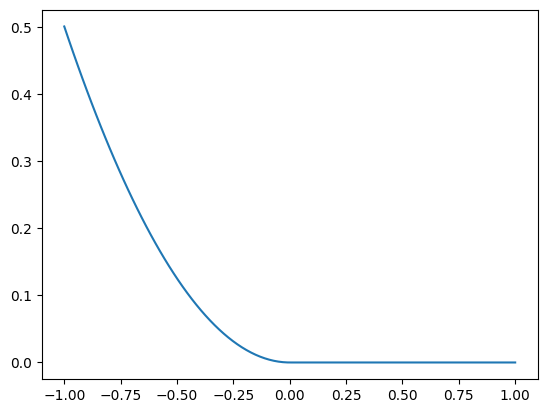

In [67]:
import matplotlib.pyplot as plt
xx = jnp.linspace(-1, 1, 100)
plt.plot(xx, jax.vmap(barrier_fn)(xx))

In [62]:
class Problem:
    pass
prob = Problem()
setattr(prob, "objective", partial(objective, pose_d=pose_d))
setattr(prob, "gradient", partial(gradient, pose_d=pose_d))
#setattr(prob, "hessian", partial(hessian, pose_d=pose_d))

In [63]:
ipopt = cyipopt.Problem(
    n=7, m=0,
    problem_obj=prob,
    lb=panda.lb, ub=panda.ub
)
ipopt.add_option("acceptable_tol", 0.01)
ipopt.add_option("acceptable_iter", 2)
x, info = ipopt.solve(panda.neutral)

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8604290e+00 0.00e+00 2.54e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [2781]:
jax.jacrev(gradient)(q, pose_d)

Array([[ 1.2373587 , -0.35075617, -0.11679628,  0.55127156,  0.3999071 ,
         0.9126858 , -0.46408626],
       [-0.35075608,  1.4583423 ,  0.00791424, -1.3408796 ,  0.11188404,
        -0.98135954, -0.6616734 ],
       [-0.1167964 ,  0.00791446,  1.0836773 ,  0.5758198 , -0.7744304 ,
         0.90825063, -1.193814  ],
       [ 0.5512715 , -1.3408797 ,  0.5758201 ,  1.5524455 , -0.00327603,
         1.1252959 ,  0.6630395 ],
       [ 0.39990687,  0.11188365, -0.7744309 , -0.00327579,  0.9205462 ,
        -0.8081528 ,  1.170286  ],
       [ 0.91268563, -0.9813594 ,  0.90825063,  1.1252959 , -0.8081528 ,
         1.1803583 ,  0.5579082 ],
       [-0.46408588, -0.66167367, -1.1938145 ,  0.6630397 ,  1.1702862 ,
         0.5579084 ,  1.1281269 ]], dtype=float32)

In [2787]:
ee, jac = get_ee_fk_jac(q)
error = to_posevec(pose_d) - ee

Array([[ 1.2373583 , -0.35075605, -0.11679614,  0.55127126,  0.39990687,
         0.91268545, -0.4640863 ],
       [-0.3507561 ,  1.4583428 ,  0.00791438, -1.3408797 ,  0.11188391,
        -0.98135966, -0.66167384],
       [-0.11679649,  0.00791433,  1.0836773 ,  0.5758201 , -0.7744307 ,
         0.90825063, -1.1938144 ],
       [ 0.55127144, -1.3408799 ,  0.5758201 ,  1.5524458 , -0.00327599,
         1.1252956 ,  0.6630397 ],
       [ 0.39990664,  0.111884  , -0.77443093, -0.00327598,  0.92054635,
        -0.8081529 ,  1.1702865 ],
       [ 0.9126854 , -0.98135954,  0.9082507 ,  1.1252959 , -0.8081529 ,
         1.1803582 ,  0.55790865],
       [-0.46408582, -0.6616738 , -1.1938143 ,  0.6630397 ,  1.1702862 ,
         0.55790854,  1.1281264 ]], dtype=float32)

In [2768]:
get_ee_hess(q)

(6, 7, 7)

In [7]:
ee, jac = get_ee_fk_jac(panda.neutral)

In [2531]:
W = np.diag([1,1,1,0.3,0.3,0.3])
def to_posevec(pose:SE3):
    return jnp.hstack([
        pose.translation(), pose.rotation().log()
    ])
def to_SE3(posevec:Array):
    return SE3.from_rotation_and_translation(
        SO3.exp(posevec[3:]), posevec[:3]
    )

def pose_error_vg(q, target:SE3):
    ee_posevec, jac = get_ee_fk_jac(q)
    target_posevec = to_posevec(target)
    err = (target_posevec - ee_posevec)
    val = 1/2 * err@W@err
    grad = - jac.T @ W @err
    return val, grad

def pose_error(q, target:SE3):
    ee_posevec, _ = get_ee_fk_jac(q)
    target_posevec = to_posevec(target)
    err = (target_posevec - ee_posevec)
    val = 1/2 * err@W@err
    return val

In [2640]:
def cost_joint_violation(q):
    ub_viol = jax.vmap(barrier_fn)(panda.ub - q).sum()
    lb_viol = jax.vmap(barrier_fn)(q - panda.lb).sum()
    return ub_viol + lb_viol

In [2644]:
def vg_objective(q, target):
    loss_main, grad_main = pose_error_vg(q, target)
    loss_joint_viol, grad_joint_viol = jax.value_and_grad(cost_joint_violation)(q)
    total_loss = loss_main + loss_joint_viol
    total_grad = grad_main + grad_joint_viol
    return total_loss, total_grad

In [2648]:
pose_d = make_pose()
frame.set_pose(pose_d)

In [2649]:
q = panda.neutral

In [2730]:
#gradient descent
val, grad = vg_objective(q, pose_d)
q += - grad * 0.5

panda.set_joint_angles(q)
print(val)

0.009140609


In [2731]:
#BFGS initialize
q = panda.neutral
B = None
q_prev = None
grad_prev = None
def bfgs_update(x, grad, B_prev, x_prev, grad_prev):
    if B_prev is None:
        return jnp.eye(7)
    
    y = x - x_prev
    s = grad - grad_prev
    
    if s@y >= 0.2*s@B_prev@s:
        theta = 1.
    else:
        theta = (0.8* s @ B_prev @ s) / (s @ B_prev @ s - s@y)
    r = theta*y + (1-theta) * B_prev@s
    term1 = (B_prev @ jnp.outer(s, s) @ B_prev) / (s @ B_prev @ s)
    term2 = jnp.outer(r, r) / jnp.inner(s, r)
    B = B_prev - term1 + term2
    return B

In [2754]:
q_old = panda.neutral
grad_old = None

#hessinv = jnp.eye(7)
ee, jac = get_ee_fk_jac(q_old)
hessinv = jnp.linalg.pinv(jac.T@jac)

In [2758]:
#BFGS
val, grad = vg_objective(q_old, pose_d)
d = - hessinv @ grad

alpha = 0.2
for i in range(10):
    val_new, _ = vg_objective(q_old + d*alpha, pose_d)
    if val_new < val:
        break
    alpha *= 0.5
print(alpha, val, val_new)
q = q_old + d * alpha
panda.set_joint_angles(q)

if grad_old is not None:
    s = q - q_old
    y = grad - grad_old
    lo = 1/y@s
    term1 = (jnp.eye(7) - lo*jnp.outer(s, y))
    term2 = lo*jnp.outer(s, s)
    hessinv = term1 @ hessinv @ term1 + term2

q_old = q
grad_old = grad



0.0001953125 0.4550761 0.46188644


In [2763]:
jnp.linalg.eigh(hessinv)

(Array([-1.5702103e+02, -1.3563424e-02,  1.1609587e-01,  7.3273629e-01,
         3.2807806e+00,  5.8992486e+00,  1.9449794e+02], dtype=float32),
 Array([[-6.50360882e-02, -5.91281116e-01,  7.07131565e-01,
          1.34677365e-01,  3.52382243e-01,  5.57234399e-02,
          2.65752673e-02],
        [-9.62386578e-02, -1.93992063e-01, -1.36382788e-01,
          6.83882087e-02, -2.40741804e-01,  5.61089933e-01,
          7.46357858e-01],
        [-3.12304318e-01,  7.44803488e-01,  4.66793150e-01,
          2.12217942e-01,  1.51280701e-01,  2.74805371e-02,
          2.47307807e-01],
        [ 9.04870033e-01,  1.88260198e-01,  1.32963404e-01,
         -8.95475224e-02,  2.28258133e-01,  1.52662490e-02,
          2.60261118e-01],
        [ 1.98801771e-01, -4.52593975e-02, -1.01833127e-01,
          9.48286653e-01, -1.81691065e-01, -4.24637571e-02,
         -1.18310705e-01],
        [ 9.82911587e-02,  1.43288583e-01,  9.91216674e-02,
         -3.72550674e-02, -1.36778373e-02,  8.13544333e-01,


In [2752]:
val

Array(342.9606, dtype=float32)

In [2753]:
val_new

Array(1.5560649e+21, dtype=float32)

In [2751]:
cost_joint_violation(q)

Array(3.8901622e+20, dtype=float32)

In [2582]:
d

Array([  507.10568, -1404.4316 ,   507.09488, -3428.895  ,  -294.80157,
        1616.1353 ,  1264.3207 ], dtype=float32)

In [2581]:
d*alpha

Array([  3.9617631, -10.972122 ,   3.9616787, -26.788242 ,  -2.3031373,
        12.626057 ,   9.877505 ], dtype=float32)

In [2550]:


panda.set_joint_angles(q)
print(np.linalg.cond(hessinv))

print(d)
# print(val)

1508304900.0
[-0.27859747 -2.6939433  -0.27860528 -3.0331087  -0.03210449  0.78300124
 -0.7162119 ]


In [2552]:
q

Array([-0.27859747, -2.6939433 , -0.27860528, -4.6039085 , -0.03210449,
        2.6505013 , -0.7162119 ], dtype=float32)

In [2529]:
def backtracking(fn, x, grad, dir, gamma=0.1, beta=0.5):
    alpha = 1.
    while True:
        loss_new = fn(x+alpha*dir)
        if loss_new < fn(x) + gamma*alpha*grad@dir:
            break
        alpha *= beta
    return alpha

In [2227]:
d

Array([ 0.0747771 , -0.10610348, -0.06143628, -0.02604391,  0.00334038,
       -0.10127855, -0.06398959], dtype=float32)

In [1906]:
hessinv

Array([[ 1.1812234 ,  0.30529368, -0.03311538,  0.66145533,  0.01423913,
        -0.47132096, -0.10083446],
       [ 0.33026755,  2.2835777 ,  0.17640345,  2.0432599 ,  0.15999584,
        -0.6592719 ,  0.08879264],
       [-0.00505848,  0.16392134,  1.0475916 ,  0.11829358,  0.04024332,
         0.05652528,  0.07635152],
       [ 0.70167774,  2.015085  ,  0.11685208,  4.4692903 ,  0.20959944,
        -1.7142216 , -0.11025082],
       [ 0.04213981,  0.13811801,  0.01059251,  0.17302808,  1.0257529 ,
        -0.0619807 ,  0.02137624],
       [-0.38510168, -0.7237274 ,  0.02595002, -1.6845617 , -0.01022426,
         2.03739   ,  0.23995887],
       [-0.06180756,  0.06783802,  0.06439261, -0.08898787,  0.03919396,
         0.2485591 ,  1.1240275 ]], dtype=float32)

Array([[1.0000023e+00, 1.5280120e-05, 1.8155987e-06, 1.0798500e-05,
        3.5691205e-06, 5.1402021e-06, 5.9737577e-06],
       [1.9887753e-05, 1.0001374e+00, 1.6343642e-05, 9.7205848e-05,
        3.2128479e-05, 4.6271027e-05, 5.3774522e-05],
       [2.8244926e-06, 1.9534866e-05, 1.0000023e+00, 1.3805340e-05,
        4.5629413e-06, 6.5714912e-06, 7.6371480e-06],
       [1.0539757e-05, 7.2895484e-05, 8.6615109e-06, 1.0000516e+00,
        1.7026878e-05, 2.4521896e-05, 2.8498460e-05],
       [4.8363313e-06, 3.3449225e-05, 3.9744691e-06, 2.3638650e-05,
        1.0000079e+00, 1.1252252e-05, 1.3076960e-05],
       [1.0672395e-05, 7.3812836e-05, 8.7705121e-06, 5.2163719e-05,
        1.7241153e-05, 1.0000248e+00, 2.8857101e-05],
       [9.3470071e-06, 6.4646127e-05, 7.6813158e-06, 4.5685585e-05,
        1.5100000e-05, 2.1746830e-05, 1.0000253e+00]], dtype=float32)

In [1146]:
jnp.linalg.eigh(B)

(Array([-8.3028152e+09, -2.1288690e+02, -5.9218149e+00,  3.0300287e+01,
         3.3294254e+01,  4.6074253e+01,  1.8210051e+04], dtype=float32),
 Array([[ 3.7803671e-01, -3.1674394e-01, -3.2739884e-01,  5.6621940e-14,
         -2.1233696e-01, -7.7572584e-01, -5.2286383e-02],
        [ 3.7703860e-01, -3.1590542e-01, -3.2653382e-01,  4.6528113e-13,
         -2.1177967e-01,  4.6648118e-01,  6.2367141e-01],
        [ 3.7812242e-01,  5.2110291e-01, -3.2747400e-01,  6.4672291e-01,
          2.1144123e-01,  5.9145492e-02, -1.0853496e-01],
        [ 3.7863982e-01,  1.1041661e-01, -3.2792053e-01, -6.4584005e-01,
          2.1173027e-01,  2.5091797e-01, -4.6044454e-01],
        [ 3.7754133e-01,  5.8411288e-01,  4.3593416e-01, -2.8735346e-01,
         -3.6894223e-01, -1.5692441e-01,  2.8795910e-01],
        [ 3.7870082e-01, -3.4156883e-01,  4.3727407e-01,  2.8647515e-01,
         -3.7007192e-01,  2.7475089e-01, -5.0418115e-01],
        [ 3.7766880e-01, -2.4141216e-01,  4.3608189e-01, -5.5894128e-

In [744]:
q = panda.neutral
ee, jac = get_ee_fk_jac(q)
val, grad = pose_error_vg(q, pose_d)
B = jac.T@jac

In [704]:
c = 1e-4

In [1111]:
B

Array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

In [1078]:
def dynamic_regularization(hess, grad):
    c = 1e-4
    for _ in range(100):
        d = jnp.linalg.solve(hess + c*np.eye(7), -grad)
        if grad @ d > 0. or jnp.isnan(grad @ d):
            c *= 10
        else:
            break
    return d

Array([ 0.05500219, -0.4103809 ,  0.05500209,  0.3176619 , -0.06514763,
        0.27199683, -0.1408904 ], dtype=float32)

In [724]:
alphas = np.array([0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000])

In [732]:
@jax.jit
def check_search_dir(alpha, B, grad):
    cI = np.eye(7) * alpha
    d = jnp.linalg.solve(B+cI, -grad)
    return grad @ d

check_search_dir_batch = jax.vmap(check_search_dir, in_axes=(0, None, None))
check_search_dir_batch = jax.jit(check_search_dir_batch)

In [743]:
idx = (~jnp.isnan(check_search_dir_batch(alphas, B, grad))).argmax()

In [733]:
%timeit check_search_dir(alphas[1], B, grad)

99.7 µs ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [730]:
%timeit check_search_dir_batch(alphas, B, grad)

107 µs ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [713]:
jnp.B

Array([[nan,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan,  0.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

In [709]:
%timeit jnp.linalg.solve(B, -grad)

96.6 µs ± 225 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [699]:
d = jnp.linalg.solve(np.eye(7), -grad)

In [700]:
grad@d

Array(-2.6775446, dtype=float32)

In [670]:
np.linalg.solve(B, -grad)

array([nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [664]:
np.linalg.cond(B)

1.0000663

In [666]:
-grad

Array([nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [658]:
B

Array([[ 1.10002656e+05, -6.74129426e-02,  2.65117145e+00,
         6.74131066e-02, -5.43157458e-02,  6.74127787e-02,
        -2.22398996e+00],
       [-6.74129426e-02,  1.10002547e+05, -6.74129426e-02,
        -2.41717505e+00, -4.51080114e-01, -2.16365004e+00,
        -6.74130619e-02],
       [ 2.65117145e+00, -6.74129426e-02,  1.10002656e+05,
         6.74131066e-02, -5.43157458e-02,  6.74127787e-02,
        -2.22398996e+00],
       [ 6.74131066e-02, -2.41717505e+00,  6.74131066e-02,
         1.10002414e+05,  4.51080114e-01,  2.20752859e+00,
         6.74129426e-02],
       [-5.43157458e-02, -4.51080114e-01, -5.43157458e-02,
         4.51080114e-01,  1.10001250e+05,  4.51080173e-01,
         5.09749830e-01],
       [ 6.74127787e-02, -2.16365004e+00,  6.74127787e-02,
         2.20752859e+00,  4.51080173e-01,  1.10002172e+05,
         6.74132407e-02],
       [-2.22398996e+00, -6.74130619e-02, -2.22398996e+00,
         6.74129426e-02,  5.09749830e-01,  6.74132407e-02,
         1.1000228

In [480]:
alphas = jnp.linspace(0.001, 1)

In [483]:
val, _ = pose_error_vg(q+d*alphas[0], pose_d) 

In [484]:
val

Array(0.00174708, dtype=float32)

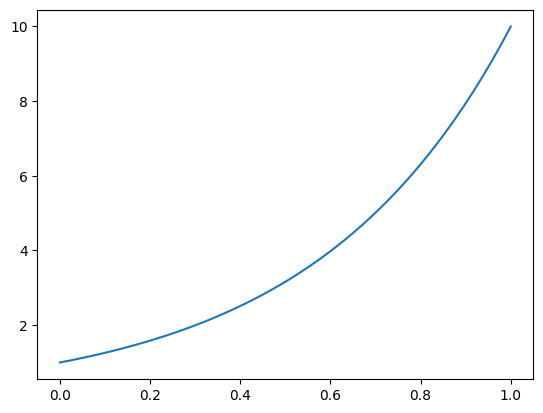

In [471]:
import matplotlib.pyplot as plt
plt.plot(xx,yy)

In [464]:
B

In [13]:
def objective(x, target:SE3):
    val = pose_error(x, target)
    panda.set_joint_angles(x)
    #traj.reload(points=get_ee_points(to_mat(x)))
    return val

def gradient(x, target:SE3):
    grads = pose_error_grad(x, target)
    return grads

def hessian(x, lagrange, obj_factor):
    return pose_error_hess(x)

In [65]:
class Prob:
    pass
prob = Prob()
setattr(prob, "objective", partial(objective, target=pose_d))
setattr(prob, "gradient", partial(gradient, target=pose_d))
# setattr(prob, "constraints", partial(constraints, q0=panda.neutral))
# setattr(prob, "jacobian", partial(jacobian, q0=panda.neutral))
# setattr(prob, "hessian", hessian)

ipopt = cyipopt.Problem(
    n=len(x), m=0,
    problem_obj=prob,
    lb=panda.lb, ub=panda.ub,
    #cl=np.zeros(dim*2), cu=np.full(dim*2,np.inf)
)
ipopt.add_option("nlp_scaling_method", "none")
ipopt.add_option("mu_strategy", "adaptive")
ipopt.add_option("acceptable_tol", 0.01)
#ipopt.add_option("acceptable_obj_change_tol", 0.001)
ipopt.add_option("acceptable_iter", 2)
#ipopt.add_option("max_iter", 100)
xsol, info = ipopt.solve(panda.neutral)

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7455500e+00 0.00e+00 1.15e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 